In [1]:
%matplotlib inline
from Chapter5.DistanceMetrics import InstanceDistanceMetrics
from Chapter5.DistanceMetrics import PersonDistanceMetricsNoOrdering
from Chapter5.DistanceMetrics import PersonDistanceMetricsOrdering
from Chapter5.Clustering import NonHierarchicalClustering
from Chapter5.Clustering import HierarchicalClustering
from util.VisualizeDataset import VisualizeDataset
from IPython.display import display
from scipy.cluster.hierarchy import dendrogram

import util.util as util
import sys
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os


plt.rcParams['figure.dpi'] = 100



In [2]:
def plot_xy(x, y, method='plot', xlabel=None, ylabel=None, xlim=None, ylim=None, names=None,
            line_styles=None, loc=None, title=None):
    for input in x, y:
        if not hasattr(input[0], '__iter__'):
            raise TypeError('x/y should be given as a list of lists of coordinates')

    plot_method = getattr(plt, method)
    for i, (x_line, y_line) in enumerate(zip(x, y)):

        plot_method(x_line, y_line, line_styles[i]) if line_styles is not None else plt.plot(x_line, y_line)

        if xlabel is not None: plt.xlabel(xlabel)
        if ylabel is not None: plt.ylabel(ylabel)
        if xlim is not None: plt.xlim(xlim)
        if ylim is not None: plt.ylim(ylim)
        if title is not None: plt.title(title)
        if names is not None: plt.legend(names)


    plt.figure()


In [3]:
def plot_clusters_3d(data_table, data_cols, cluster_col, label_cols,title=''):

    color_index = 0
    point_displays = ['+', 'x', '*', 'd', 'o', 's', '<', '>']
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

    # Determine the number of clusters:
    
    clusters = data_table[cluster_col].unique()
    
    labels = []

    # Get the possible labels, assuming 1 or more label columns with binary values.
    for i in range(0, len(label_cols)):
        labels.extend([name for name in list(data_table.columns) if label_cols[i] == name[0:len(label_cols[i])]])
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    handles = []

    # Plot clusters individually with a certain color.
    for cluster in clusters:
        marker_index = 0
        # And make sure the points of a label receive the right marker type.
        for label in labels:
            rows = data_table.loc[(data_table[cluster_col] == cluster) & (data_table[label] > 0)]
            # Now we come to the assumption that there are three data_cols specified:
            if not len(data_cols) == 3:
                return
            # plot_color = colors[color_index%len(colors)]
            plot_color = [plt.get_cmap('Set2')(float(cluster) / len(clusters))]
            plot_marker = point_displays[marker_index%len(point_displays)]
            pt = ax.scatter(rows[data_cols[0]], rows[data_cols[1]], rows[data_cols[2]], c=plot_color, marker=plot_marker)
            if color_index == 0:
                handles.append(pt)
            ax.set_xlabel(data_cols[0])
            ax.set_ylabel(data_cols[1])
            ax.set_zlabel(data_cols[2])
            marker_index += 1
        color_index += 1

    plt.legend(handles, labels, fontsize='xx-small', numpoints=1)
    if title is not None: plt.title(title)
    # plt.show()
    plt.figure()

In [4]:
def plot_clusters_3d_our(data_table, data_cols, cluster_col, label_cols,title=''):

    color_index = 0
    point_displays = ['+', 'x', '*', 'd', 'o', 's', '<', '>']
    
    clusters = data_table[cluster_col].unique()
    
    labels = []

    # Get the possible labels, assuming 1 or more label columns with binary values.
    for i in range(0, len(label_cols)):
        labels.extend([name for name in list(data_table.columns) if label_cols[i] == name[0:len(label_cols[i])]])
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    handles = []

    # Plot clusters individually with a certain color.
    for cluster in clusters:
        marker_index = 0
        # And make sure the points of a label receive the right marker type.
        for label in labels:
            rows = data_table.loc[(data_table[cluster_col] == cluster) & (data_table[label] != '')]
            # Now we come to the assumption that there are three data_cols specified:
            if not len(data_cols) == 3:
                return
            # plot_color = colors[color_index%len(colors)]
            plot_color = [plt.get_cmap('Set2')(float(cluster) / len(clusters))]
            plot_marker = point_displays[marker_index%len(point_displays)]
            pt = ax.scatter(rows[data_cols[0]], rows[data_cols[1]], rows[data_cols[2]], c=plot_color, marker=plot_marker)
            if color_index == 0:
                handles.append(pt)
            ax.set_xlabel(data_cols[0])
            ax.set_ylabel(data_cols[1])
            ax.set_zlabel(data_cols[2])
            marker_index += 1
        color_index += 1

    plt.legend(handles, labels, fontsize='xx-small', numpoints=1)
    if title is not None: plt.title(title)
    # plt.show()
    plt.figure()

In [5]:
def plot_dendrogram(dataset, linkage):
    sys.setrecursionlimit(40000)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('time points')
    plt.ylabel('distance')
    times = dataset.index.strftime('%H:%M:%S')
    #dendrogram(linkage,truncate_mode='lastp',p=10, show_leaf_counts=True, leaf_rotation=90.,leaf_font_size=12.,show_contracted=True, labels=times)
    dendrogram(linkage,truncate_mode='lastp',p=16, show_leaf_counts=True, leaf_rotation=45.,leaf_font_size=8.,show_contracted=True, labels=times)
    
    plt.figure()

In [6]:
def plot_silhouette(data_table, cluster_col, silhouette_col):
    # Taken from the examples of scikit learn
    #(http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

    clusters = data_table[cluster_col].unique()

    fig, ax1 = plt.subplots(1, 1)
    ax1.set_xlim([-0.1, 1])
    #ax1.set_ylim([0, len(data_table.index) + (len(clusters) + 1) * 10])
    y_lower = 10
    for i in range(0, len(clusters)):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        rows = data_table.mask(data_table[cluster_col] != clusters[i])
        ith_cluster_silhouette_values = np.array(rows[silhouette_col])
        ith_cluster_silhouette_values.sort()

        size_cluster_i = len(rows.index)
        y_upper = y_lower + size_cluster_i

        color = [plt.get_cmap('Set2')(float(i) / len(clusters))]
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.05 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=data_table[silhouette_col].mean(), color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.figure()

In [21]:
# As usual, we set our program constants, read the input file and initialize a visualization object.
DATA_PATH = Path('./intermediate_datafiles/')
DATASET_FNAME = 'chapter4_result.csv'
# RESULT_FNAME = 'chapter5_result.csv'
# figure_path = os.path.abspath('figures/ch_5_1')


try:
    dataset = pd.read_csv(DATA_PATH / DATASET_FNAME, index_col=0)
    dataset.index = pd.to_datetime(dataset.index)
except IOError as e:
    print('File not found, try to run previous crowdsignals scripts first!')
    raise e

# DataViz = VisualizeDataset(figure_path)

clusteringNH = NonHierarchicalClustering()
clusteringH = HierarchicalClustering()

### K-MEANS


===== kmeans clustering =====
k = 2 	 silhouette = 0.6516851950601523
k = 3 	 silhouette = 0.6533601223162774
k = 4 	 silhouette = 0.6743770786725228
k = 5 	 silhouette = 0.6848202359126043
k = 6 	 silhouette = 0.6684133442086563
k = 7 	 silhouette = 0.6522987459248645
k = 8 	 silhouette = 0.6565540404029963
k = 9 	 silhouette = 0.6553440914569542
Highest K-Means silhouette score: k =  5


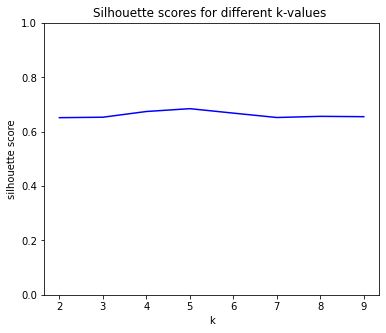

<Figure size 432x360 with 0 Axes>

In [16]:
%matplotlib inline
# Let us look at k-means first.
plt.rcParams['figure.figsize'] = [6, 5]
k_values = range(2, 10)
silhouette_values = []

# Do some initial runs to determine the right number for k

print('===== kmeans clustering =====')
for k in k_values:
    
    dataset = clusteringNH.k_means_over_instances(copy.deepcopy(dataset), ['gyr_phone_x', 'gyr_phone_y', 'gyr_phone_z'], k, 'default', 20, 10)
    silhouette_score = dataset['silhouette'].mean()
    print(f'k = {k} \t silhouette = {silhouette_score}')
    silhouette_values.append(silhouette_score)

# DataViz.plot_xy(x=[k_values], y=[silhouette_values], xlabel='k', ylabel='silhouette score', ylim=[0, 1], line_styles=['b-'],title= '')
plot_xy(x=[k_values], y=[silhouette_values], xlabel='k', ylabel='silhouette score', ylim=[0, 1], line_styles=['b-'],title= 'Silhouette scores for different k-values ')

# And run the knn with the highest silhouette score

k_kmean = k_values[np.argmax(silhouette_values)]
print('Highest K-Means silhouette score: k = ',k_kmean)



\multirow{2}{*}{ gyr_phone_x } & mean  &  -0.01 &  0.80 &  -0.91 &  1.17 &  -1.09\\
 & std  &  0.15 &  0.43 &  0.39 &  0.42 &  0.43\\
\multirow{2}{*}{ gyr_phone_y } & mean  &  0.04 &  -0.37 &  -0.14 &  0.31 &  0.16\\
 & std  &  0.22 &  0.59 &  0.51 &  0.56 &  0.58\\
\multirow{2}{*}{ gyr_phone_z } & mean  &  0.01 &  -0.50 &  -0.83 &  1.02 &  0.80\\
 & std  &  0.12 &  0.47 &  0.41 &  0.47 &  0.33\\
labelOnTable  & percentage  &  100.00 \% &  0.00 \% &  0.00 \% &  0.00 \% &  0.00 \%\\
labelSitting  & percentage  &  98.80 \% &  0.00 \% &  0.80 \% &  0.40 \% &  0.00 \%\\
labelWashingHands  & percentage  &  91.23 \% &  1.75 \% &  5.26 \% &  1.75 \% &  0.00 \%\\
labelWalking  & percentage  &  28.57 \% &  21.31 \% &  18.50 \% &  15.46 \% &  16.16 \%\\
labelStanding  & percentage  &  96.21 \% &  1.42 \% &  0.47 \% &  0.47 \% &  1.42 \%\\
labelDriving  & percentage  &  98.06 \% &  0.56 \% &  0.28 \% &  0.00 \% &  1.11 \%\\
labelEating  & percentage  &  97.46 \% &  1.02 \% &  0.51 \% &  0.51 \% &

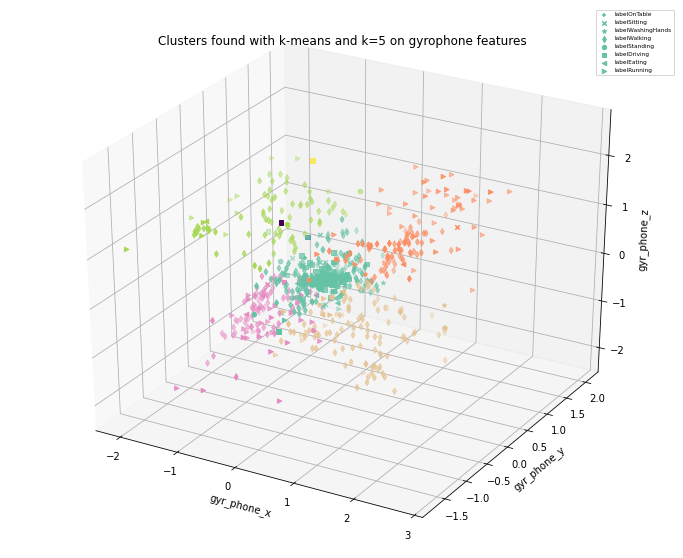

<Figure size 864x720 with 0 Axes>

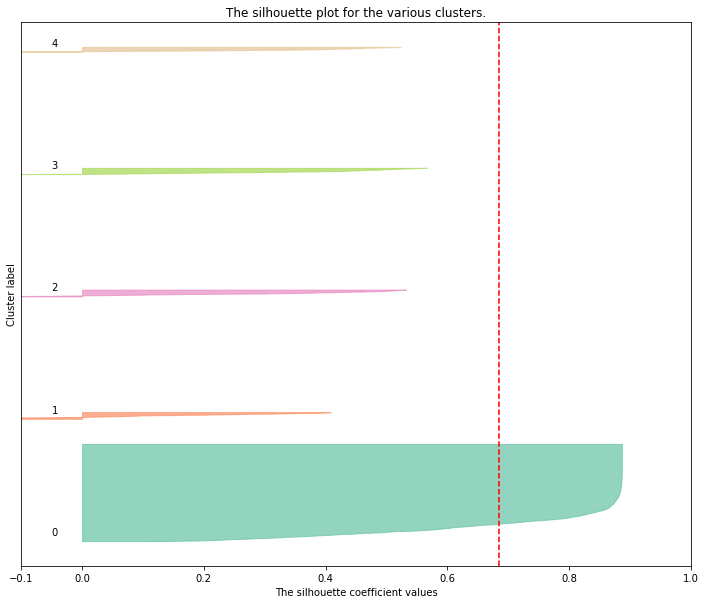

<Figure size 864x720 with 0 Axes>

In [112]:
plt.rcParams['figure.figsize'] = [12, 10]

dataset = clusteringNH.k_means_over_instances(copy.deepcopy(dataset), ['gyr_phone_x', 'gyr_phone_y', 'gyr_phone_z'], k_kmean, 'default', 20, 10)
plot_clusters_3d(copy.deepcopy(dataset), ['gyr_phone_x', 'gyr_phone_y', 'gyr_phone_z'], 'cluster', ['label'],title='Clusters found with k-means and k=5 on gyrophone features')

util.print_latex_statistics_clusters(dataset, 'cluster', ['gyr_phone_x', 'gyr_phone_y', 'gyr_phone_z'], 'label')
# del dataset['silhouette']
plot_silhouette(dataset, 'cluster', 'silhouette')

In [72]:
# dataset.iloc[dataset.loc[:,['cluster']] == 0]
print('dataset size = ',len(dataset))
print('cluster 0 size = ',len(dataset.loc[dataset['cluster'] == 0]))
print('cluster 1 size = ',len(dataset.loc[dataset['cluster'] == 1]))
print('cluster 2 size = ',len(dataset.loc[dataset['cluster'] == 2]))
print('cluster 3 size = ',len(dataset.loc[dataset['cluster'] == 3]))
print('cluster 4 size = ',len(dataset.loc[dataset['cluster'] == 4]))

dataset size =  2895
cluster 0 size =  2309
cluster 1 size =  149
cluster 2 size =  163
cluster 3 size =  116
cluster 4 size =  158
cluster 4 size =  0


## K-MEDOIDS

In [9]:
%matplotlib inline

try:
    dataset = pd.read_csv(DATA_PATH / DATASET_FNAME, index_col=0)
    dataset.index = pd.to_datetime(dataset.index)
except IOError as e:
    print('File not found, try to run previous crowdsignals scripts first!')
    raise e

# DataViz = VisualizeDataset(figure_path)

clusteringNH = NonHierarchicalClustering()
clusteringH = HierarchicalClustering()

===== k medoids clustering =====
k = 2
silhouette = 0.6736556770749162
k = 3
silhouette = 0.6356072871803918
k = 4
silhouette = 0.5975267020084861
k = 5
silhouette = 0.6238099543591858
k = 6
silhouette = 0.6369365219630738
k = 7
silhouette = 0.6448093083811915
k = 8
silhouette = 0.6275794396835744
k = 9
silhouette = 0.6146853317875778
Highest K-Medoids silhouette score: k = 2


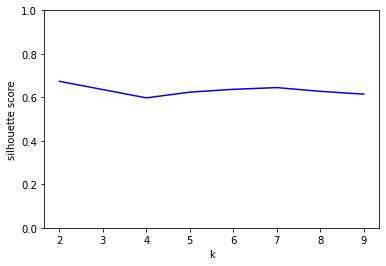

<Figure size 432x288 with 0 Axes>

In [10]:
# Do some initial runs to determine the right number for k
k_values = range(2, 10)
silhouette_values = []
print('===== k medoids clustering =====')

for k in k_values:
    print(f'k = {k}')
    dataset_cluster = clusteringNH.k_medoids_over_instances(copy.deepcopy(dataset), ['gyr_phone_x', 'gyr_phone_y', 'gyr_phone_z'], k, 'default', 20, n_inits=10)
    silhouette_score = dataset_cluster['silhouette'].mean()
    print(f'silhouette = {silhouette_score}')
    silhouette_values.append(silhouette_score)

plot_xy(x=[k_values], y=[silhouette_values], xlabel='k', ylabel='silhouette score', ylim=[0, 1], line_styles=['b-'])

# And run k medoids with the highest silhouette score
k_kmedoids = k_values[np.argmax(silhouette_values)]
print(f'Highest K-Medoids silhouette score: k = {k_kmedoids}')



\multirow{2}{*}{ gyr_phone_x } & mean  &  -0.06 &  1.13\\
 & std  &  0.42 &  0.50\\
\multirow{2}{*}{ gyr_phone_y } & mean  &  0.01 &  0.32\\
 & std  &  0.32 &  0.56\\
\multirow{2}{*}{ gyr_phone_z } & mean  &  -0.04 &  0.99\\
 & std  &  0.34 &  0.50\\
labelOnTable  & percentage  &  100.00 \% &  0.00 \%\\
labelSitting  & percentage  &  99.60 \% &  0.40 \%\\
labelWashingHands  & percentage  &  96.49 \% &  3.51 \%\\
labelWalking  & percentage  &  84.54 \% &  15.46 \%\\
labelStanding  & percentage  &  98.58 \% &  1.42 \%\\
labelDriving  & percentage  &  99.72 \% &  0.28 \%\\
labelEating  & percentage  &  99.49 \% &  0.51 \%\\
labelRunning  & percentage  &  55.05 \% &  44.95 \%\\


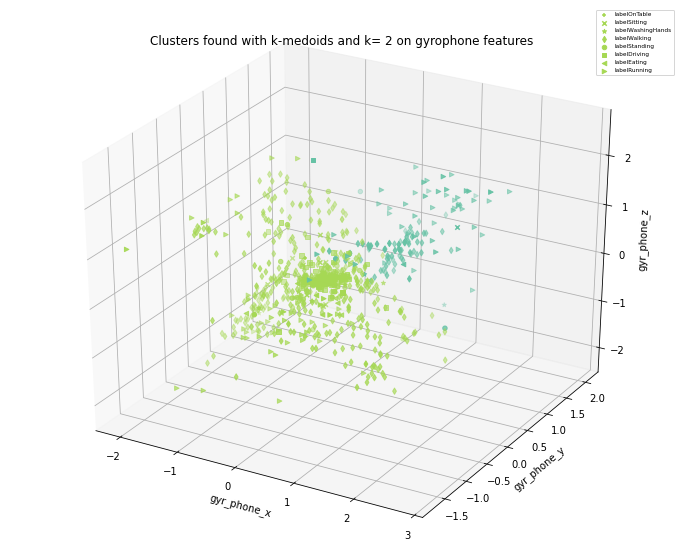

<Figure size 864x720 with 0 Axes>

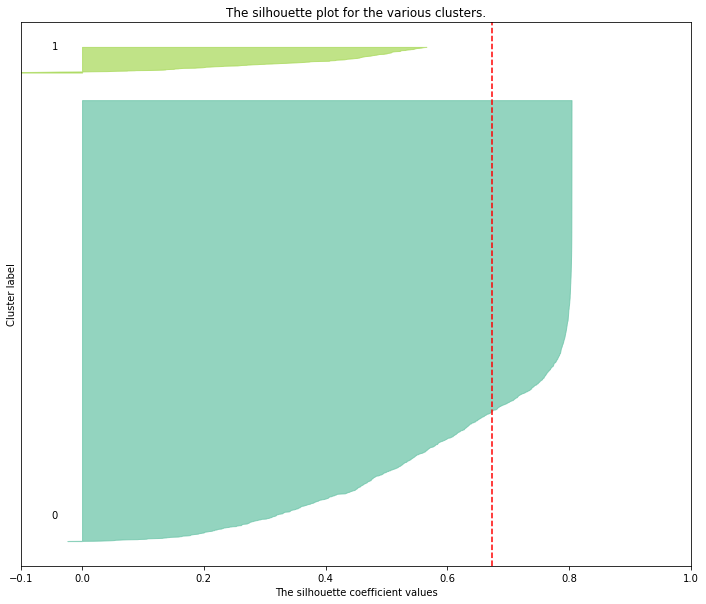

<Figure size 864x720 with 0 Axes>

In [11]:
plt.rcParams['figure.figsize'] = [12, 10]
dataset_kmed = clusteringNH.k_medoids_over_instances(copy.deepcopy(dataset), ['gyr_phone_x', 'gyr_phone_y', 'gyr_phone_z'], k_kmedoids, 'default', 20, n_inits=50)
plot_clusters_3d(copy.deepcopy(dataset_kmed), ['gyr_phone_x', 'gyr_phone_y', 'gyr_phone_z'], 'cluster', ['label'],title='Clusters found with k-medoids and k= {} on gyrophone features'.format(k_kmedoids))
plot_silhouette(dataset_kmed, 'cluster', 'silhouette')
util.print_latex_statistics_clusters(dataset_kmed, 'cluster', ['gyr_phone_x', 'gyr_phone_y', 'gyr_phone_z'], 'label')

In [15]:
# dataset.iloc[dataset.loc[:,['cluster']] == 0]
print('dataset size = ',len(dataset_kmed))
print('cluster 0 size = ',len(dataset_kmed.loc[dataset_kmed['cluster'] == 0]))
print('cluster 1 size = ',len(dataset_kmed.loc[dataset_kmed['cluster'] == 1]))
print('cluster 1 size = ',len(dataset_kmed.loc[dataset_kmed['cluster'] == 2]))


dataset size =  2895
cluster 0 size =  160
cluster 1 size =  2735
cluster 1 size =  0


## HIERARCHICAL


===== agglomerative clustering =====
k = 2
silhouette = 0.6676832244147272
k = 3
silhouette = 0.6623398255090625
k = 4
silhouette = 0.6744328097767218
k = 5
silhouette = 0.6855873627560741
k = 6
silhouette = 0.6038108797686378
k = 7
silhouette = 0.6002214412293708
k = 8
silhouette = 0.6002559752038582
k = 9
silhouette = 0.6003549065297363
\multirow{2}{*}{ gyr_phone_x } & mean  &  -0.02 &  0.04 &  0.13 &  1.18 &  1.54 &  -1.22 &  -0.57 &  1.04 &  -1.18\\
 & std  &  0.14 &  0.36 &  0.37 &  0.32 &  0.43 &  0.37 &  0.46 &  0.28 &  0.25\\
\multirow{2}{*}{ gyr_phone_y } & mean  &  0.02 &  -0.51 &  0.56 &  -0.24 &  0.85 &  0.13 &  -0.76 &  0.01 &  0.11\\
 & std  &  0.08 &  0.35 &  0.32 &  0.45 &  0.46 &  0.57 &  0.39 &  0.46 &  0.35\\
\multirow{2}{*}{ gyr_phone_z } & mean  &  -0.00 &  -0.06 &  0.04 &  -0.72 &  1.42 &  0.84 &  -0.97 &  0.81 &  -0.92\\
 & std  &  0.12 &  0.28 &  0.45 &  0.35 &  0.50 &  0.33 &  0.30 &  0.37 &  0.37\\
labelOnTable  & percentage  &  100.00 \% &  0.00 \% &  0.00 \%

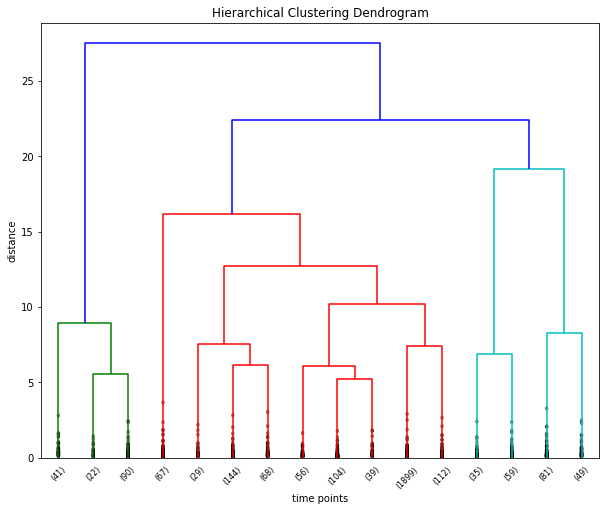

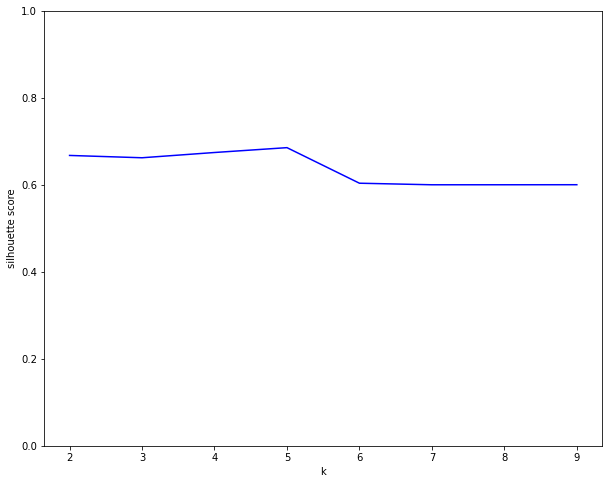

<Figure size 864x720 with 0 Axes>

In [14]:

k_values = range(2, 10)
silhouette_values = []

# Do some initial runs to determine the right number for the maximum number of clusters.

print('===== agglomerative clustering =====')
for k in k_values:
    print(f'k = {k}')
    dataset, l = clusteringH.agglomerative_over_instances(copy.deepcopy(dataset), ['gyr_phone_x', 'gyr_phone_y', 'gyr_phone_z'], k, 'euclidean', use_prev_linkage=True, link_function='ward')
    silhouette_score = dataset['silhouette'].mean()
    print(f'silhouette = {silhouette_score}')
    silhouette_values.append(silhouette_score)
    
    if k == k_values[0]:
        plt.rcParams['figure.figsize'] = [10, 8]
        plot_dendrogram(dataset, l)


plt.rcParams['figure.figsize'] = [12, 10]
plot_xy(x=[k_values], y=[silhouette_values], xlabel='k', ylabel='silhouette score',
                ylim=[0, 1], line_styles=['b-'])



\multirow{2}{*}{ gyr_phone_x } & mean  &  -0.00 &  1.18 &  1.18 &  -1.22 &  -0.95\\
 & std  &  0.20 &  0.32 &  0.39 &  0.37 &  0.45\\
\multirow{2}{*}{ gyr_phone_y } & mean  &  0.03 &  -0.24 &  0.23 &  0.13 &  -0.22\\
 & std  &  0.28 &  0.45 &  0.59 &  0.57 &  0.56\\
\multirow{2}{*}{ gyr_phone_z } & mean  &  -0.00 &  -0.72 &  0.97 &  0.84 &  -0.94\\
 & std  &  0.19 &  0.35 &  0.49 &  0.33 &  0.34\\
labelOnTable  & percentage  &  100.00 \% &  0.00 \% &  0.00 \% &  0.00 \% &  0.00 \%\\
labelSitting  & percentage  &  99.20 \% &  0.00 \% &  0.40 \% &  0.40 \% &  0.00 \%\\
labelWashingHands  & percentage  &  94.74 \% &  1.75 \% &  1.75 \% &  0.00 \% &  1.75 \%\\
labelWalking  & percentage  &  42.39 \% &  12.65 \% &  16.86 \% &  13.11 \% &  14.99 \%\\
labelStanding  & percentage  &  98.10 \% &  0.47 \% &  0.47 \% &  0.95 \% &  0.00 \%\\
labelDriving  & percentage  &  98.61 \% &  0.28 \% &  0.00 \% &  0.83 \% &  0.28 \%\\
labelEating  & percentage  &  98.48 \% &  0.00 \% &  0.51 \% &  0.51 \% 

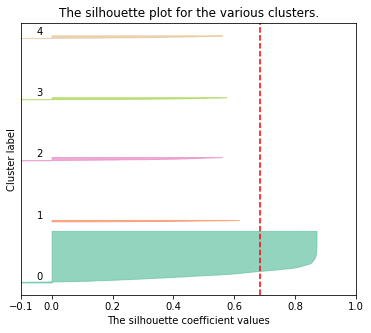

<Figure size 432x360 with 0 Axes>

In [20]:
dataset, l = clusteringH.agglomerative_over_instances(copy.deepcopy(dataset), ['gyr_phone_x', 'gyr_phone_y', 'gyr_phone_z'], 5, 'euclidean', use_prev_linkage=True, link_function='ward')
util.print_latex_statistics_clusters(dataset, 'cluster', ['gyr_phone_x', 'gyr_phone_y', 'gyr_phone_z'], 'label')
plot_silhouette(dataset, 'cluster', 'silhouette')

## 2. OUR OWN DATASET

In [23]:
DATA_PATH = Path('./our_datasets/ch2_1/')
DATASET_FNAME = 'boxing_data_edited.csv'

try:
    our_dataset = pd.read_csv(DATA_PATH / DATASET_FNAME)
    our_dataset_raw = pd.read_csv(Path('./our_datasets/ch2_1_raw/') / 'boxing_data.csv')
    our_dataset.index = pd.to_datetime(our_dataset.index)
except IOError as e:
    print('File not found, try to run previous crowdsignals scripts first!')
    raise e

# DataViz = VisualizeDataset(figure_path)
our_dataset = our_dataset.rename(columns={"x": "acc_x"})
our_dataset = our_dataset.rename(columns={"y": "acc_y"})
our_dataset = our_dataset.rename(columns={"z": "acc_z"})

clusteringNH = NonHierarchicalClustering()
clusteringH = HierarchicalClustering()

===== kmeans clustering =====
k = 2
silhouette = 0.7750015612860326
k = 3
silhouette = 0.5201791533013511
k = 4
silhouette = 0.5039101053237235
k = 5
silhouette = 0.5117997532795039
k = 6
silhouette = 0.5026399436664953
k = 7
silhouette = 0.47583929419097626
k = 8
silhouette = 0.4717006742584722
k = 9
silhouette = 0.4741040423146714
Highest K-Means silhouette score: k =  2


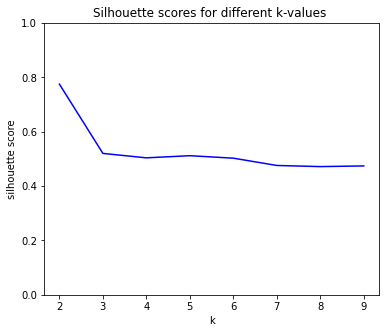

<Figure size 432x360 with 0 Axes>

In [54]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 5]
k_values = range(2, 10)
silhouette_values = []

print('===== kmeans clustering =====')
for k in k_values:
    print(f'k = {k}')
    our_dataset = clusteringNH.k_means_over_instances(copy.deepcopy(our_dataset), ['acc_x', 'acc_y', 'acc_z'], k, 'default', 20, 10)
    silhouette_score = our_dataset['silhouette'].mean()
    print(f'silhouette = {silhouette_score}')
    silhouette_values.append(silhouette_score)

plot_xy(x=[k_values], y=[silhouette_values], xlabel='k', ylabel='silhouette score', ylim=[0, 1], line_styles=['b-'],title= 'Silhouette scores for different k-values ')

our_k_kmean = k_values[np.argmax(silhouette_values)]
print('Highest K-Means silhouette score: k = ',our_k_kmean)

In [24]:
plt.rcParams['figure.figsize'] = [12, 10]

our_dataset = clusteringNH.k_means_over_instances(our_dataset, ['acc_x', 'acc_y', 'acc_z'], 2, 'default', 20, 10)


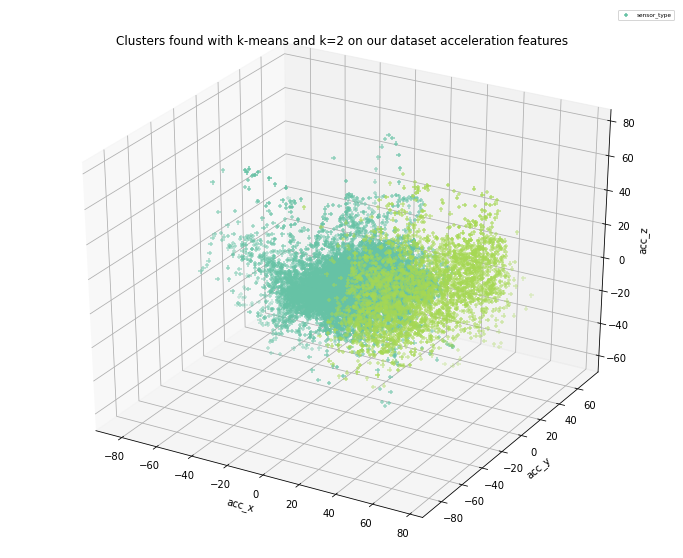

<Figure size 864x720 with 0 Axes>

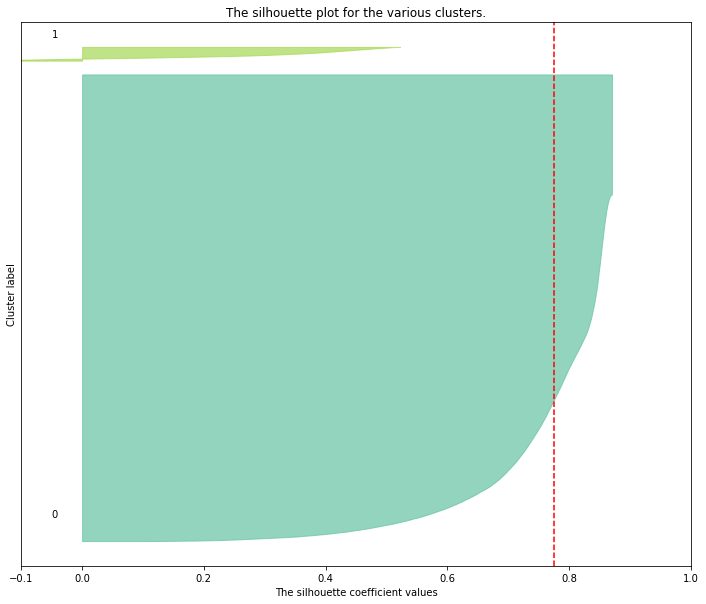

<Figure size 864x720 with 0 Axes>

In [27]:
plot_clusters_3d_our(our_dataset, ['acc_x', 'acc_y', 'acc_z'], 'cluster', ['sensor'],title='Clusters found with k-means and k=2 on our dataset acceleration features')
plot_silhouette(our_dataset, 'cluster', 'silhouette')

In [105]:
our_dataset.head()

,timestamps,acc_x,acc_y,acc_z,Absolute acceleration (m/s^2),sensor_type,device_type,cluster,silhouette
1970-01-01 00:00:00.000000000,1.654585e+18,-0.012595,0.234416,0.261410,0.351347,accelerometer,smartphone,0,0.868901
1970-01-01 00:00:00.000000001,1.654585e+18,0.071366,0.244199,0.210297,0.330077,accelerometer,smartphone,0,0.868908
1970-01-01 00:00:00.000000002,1.654585e+18,0.160429,0.196512,0.151078,0.295261,accelerometer,smartphone,0,0.868960
1970-01-01 00:00:00.000000003,1.654585e+18,0.392639,0.234954,0.118217,0.472593,accelerometer,smartphone,0,0.867736
1970-01-01 00:00:00.000000004,1.654585e+18,0.702538,0.352884,0.162493,0.802802,accelerometer,smartphone,0,0.865459


In [109]:
util.print_latex_statistics_clusters(our_dataset, 'cluster', ['acc_x', 'acc_y', 'acc_z'], 'label')
# del dataset['silhouette']
# plot_silhouette(our_dataset, 'cluster', 'silhouette')

\multirow{2}{*}{ acc_x } & mean  &  -0.55 &  44.18\\
 & std  &  8.21 &  18.63\\
\multirow{2}{*}{ acc_y } & mean  &  -0.76 &  -23.93\\
 & std  &  7.09 &  17.85\\
\multirow{2}{*}{ acc_z } & mean  &  -0.34 &  16.86\\
 & std  &  4.95 &  17.75\\


In [128]:
our_dataset['sensor_type'] != ''

1970-01-01 00:00:00.000000000    True
1970-01-01 00:00:00.000000001    True
1970-01-01 00:00:00.000000002    True
1970-01-01 00:00:00.000000003    True
1970-01-01 00:00:00.000000004    True
                                 ... 
1970-01-01 00:00:00.000095257    True
1970-01-01 00:00:00.000095258    True
1970-01-01 00:00:00.000095259    True
1970-01-01 00:00:00.000095260    True
1970-01-01 00:00:00.000095261    True
Name: sensor_type, Length: 95262, dtype: bool